In [1]:
import os
print(os.getcwd())
os.chdir(os.path.dirname(os.getcwd()))
print(os.getcwd()) 


/home/mbortkie/repos/crl_subgoal/src/notebooks
/home/mbortkie/repos/crl_subgoal/src


In [2]:
import functools
import os

import wandb
import distrax

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs


In [3]:
EPISODE_LENGTH = 100
NUM_ENVS = 8

In [4]:
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=5,
        number_of_boxes_min=3,
        number_of_boxes_max=7,
        number_of_moving_boxes_max=5
    )
)

In [5]:
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))

dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    'observations':dummy_timestep.grid.reshape(1, -1),  # Add batch dimension 
    'next_observations': dummy_timestep.grid.reshape(1, -1),
    'actions': jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space-1), # TODO: make sure it should be the maximal value of action space  # Single action for batch size 1
    'rewards': dummy_timestep.reward.reshape(1, -1),
    'masks': 1.0 - dummy_timestep.reward.reshape(1, -1), 
    'value_goals': dummy_timestep.grid.reshape(1, -1),
    'actor_goals': dummy_timestep.grid.reshape(1, -1),
}

In [6]:
agent, config = restore_agent(example_batch, "/home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0/", 50)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/test_generalization_sc_YHIWZ6/runs/long_moving_boxes_5_grid_5_range_3_7_alpha_0.0//params_50.pkl


In [7]:
keys = random.split(random.PRNGKey(0), 8)
state, info = env.reset(keys)


In [8]:
agent.sample_actions(state.grid.reshape(state.grid.shape[0], -1), state.goal.reshape(state.goal.shape[0], -1), seed=random.PRNGKey(0))

Array([1, 2, 2, 5, 2, 0, 0, 2], dtype=int32)

In [9]:
_, info, timesteps = collect_data(agent, key, env, NUM_ENVS, EPISODE_LENGTH, use_targets=False)
timesteps = jax.tree_util.tree_map(lambda x: x.swapaxes(1, 0), timesteps)


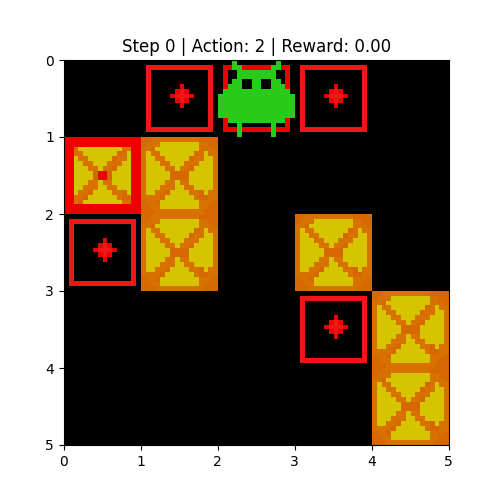

In [10]:
import IPython.display as display

grid_size = state.grid.shape[-2:]
fig, ax = plt.subplots(figsize=grid_size)

animate = functools.partial(env.animate, ax, timesteps, img_prefix=os.path.join(ROOT_DIR, 'assets'))

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=EPISODE_LENGTH, interval=80, repeat=False)

# Save as GIF
gif_path = f"/tmp/block_moving_epoch.gif"
anim.save(gif_path, writer='pillow')
plt.close()


# Visualize the GIF in the notebook
display.display(display.Image(filename=gif_path))


In [11]:
timesteps.grid.shape

(8, 100, 5, 5)

In [12]:
timesteps_tr = jax.tree_util.tree_map(lambda x: x[0], timesteps)

timesteps_tr.grid.shape

(100, 5, 5)

In [13]:
use_targets = False


timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps_tr.replace(),
    lambda: timesteps_tr.replace(
        grid=GridStatesEnum.remove_targets(timesteps_tr.grid),
        goal=GridStatesEnum.remove_targets(timesteps_tr.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal

In [14]:
tr_states[0]

Array([[0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0],
       [3, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1]], dtype=int8)

In [15]:
print(f"timesteps_tr.grid.shape: {timesteps_tr.grid.shape}")
print(f"timesteps_tr.action.shape: {timesteps_tr.action.shape}")
print(f"timesteps_tr.goal.shape: {timesteps_tr.goal.shape}")

timesteps_tr.grid.shape: (100, 5, 5)
timesteps_tr.action.shape: (100,)
timesteps_tr.goal.shape: (100, 5, 5)


In [16]:
tr_actions[-20:]

Array([2, 5, 0, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [17]:
tr_states.shape

(100, 5, 5)

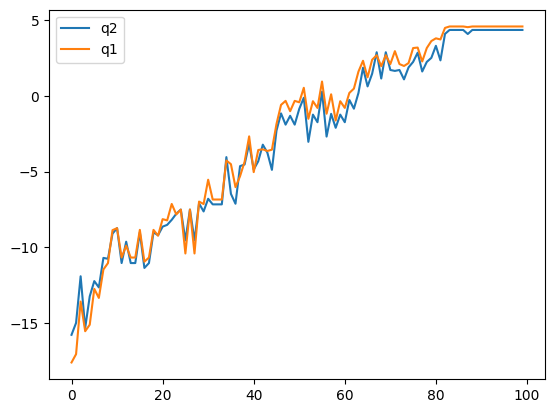

In [52]:
q1, q2 = agent.network.select('critic')(tr_states.reshape(tr_states.shape[0], -1), tr_goals.reshape(tr_goals.shape[0], -1), tr_actions.reshape(tr_actions.shape[0]))

plt.plot(jnp.log(q2), label='q2')
plt.plot(jnp.log(q1), label='q1')
plt.legend()
plt.show()

In [19]:
dist = agent.network.select('actor')(tr_states.reshape(tr_states.shape[0], -1), tr_goals.reshape(tr_goals.shape[0], -1), temperature=1)
actions = dist.sample(seed=jax.random.PRNGKey(0))


2025-07-22 20:06:51.233115: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [20]:
dist.logits.shape

(100, 6)

In [21]:
dist.probs.shape

(100, 6)

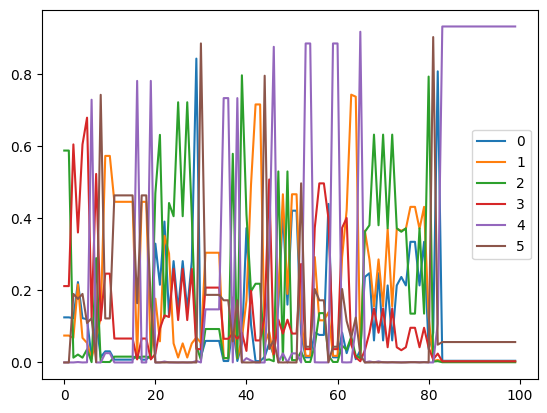

In [22]:
for i in range(dist.probs.shape[1]):
    plt.plot(dist.probs[:,i], label=f'{i}')
plt.legend()
plt.show()

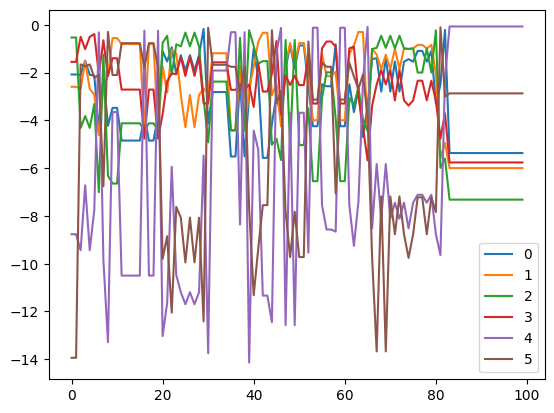

In [23]:
for i in range(dist.logits.shape[1]):
    plt.plot(dist.logits[:,i], label=f'{i}')
plt.legend()
plt.show()

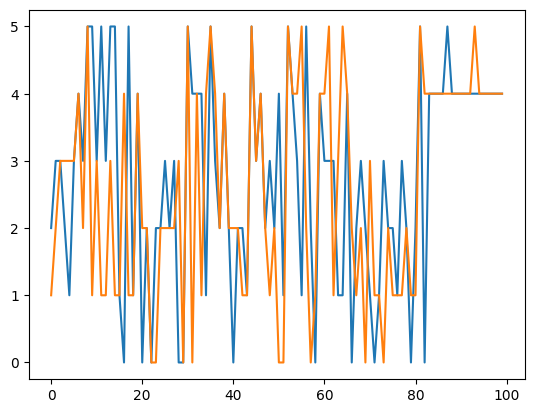

In [24]:
plt.plot(tr_actions)
plt.plot(actions)
plt.show()

# Distribution of actions based on Q values

In [32]:
def value_transform(x):
    return jnp.log(jnp.maximum(x, 1e-6))
all_actions = jnp.tile(jnp.arange(6), (tr_states.shape[0], 1))  # B x 6
print(f"all_actions.shape: {all_actions.shape}")
qs = jax.vmap(agent.network.select('critic'), in_axes=(None, None, 1))(tr_states.reshape(tr_states.shape[0], -1), tr_goals.reshape(tr_goals.shape[0], -1), all_actions) # 6 x 2 x B
qs = qs.min(axis=1) # 6 x B
print(f"qs.shape: {qs.shape}")
# qs_argmax_actions = jnp.argmax(qs, axis=0) # B
qs = value_transform(qs)

all_actions.shape: (100, 6)
qs.shape: (6, 100)


In [33]:
qs = qs.transpose(1, 0)
qs.shape

(100, 6)

In [ ]:
distribution_from_qs = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
distribution_from_qs_temp_0_1 = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 0.1))
distribution_from_qs_temp_0_5 = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 0.5))
distribution_from_qs_temp_10 = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 10))

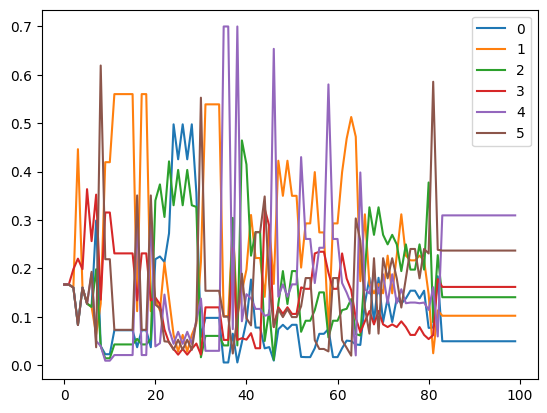

In [49]:
for i in range(distribution_from_qs.probs.shape[1]):
    plt.plot(distribution_from_qs.probs[:,i], label=f'{i}')
plt.legend()
plt.show()

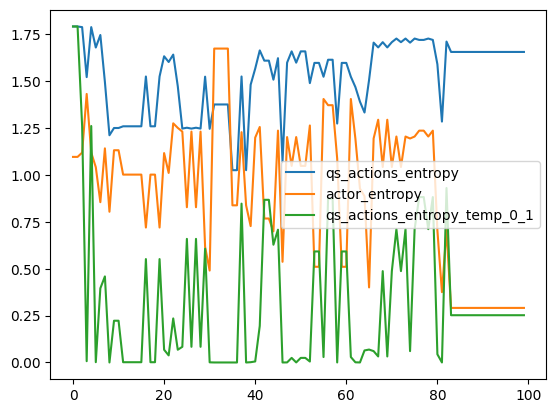

In [53]:
plt.plot(distribution_from_qs.entropy(), label='qs_actions_entropy')
plt.plot(dist.entropy(), label='actor_entropy')
# plt.plot(distribution_from_qs_temp_0_5.entropy(), label='qs_actions_entropy_temp_0_5')
plt.plot(distribution_from_qs_temp_0_1.entropy(), label='qs_actions_entropy_temp_0_1')
# plt.plot(distribution_from_qs_temp_10.entropy(), label='qs_actions_entropy_temp_10')
plt.legend()
plt.show()

### Q in time

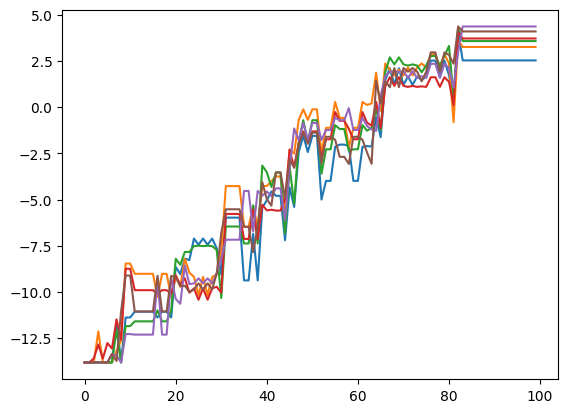

In [42]:
for i in range(qs.shape[1]):
    plt.plot(qs[:,i])
plt.show()